<a href="https://colab.research.google.com/github/viva198/zadaniya/blob/main/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [ ]:
!pip install pandas scikit-learn seaborn scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [ ]:
# Загрузка набора данных
df = pd.read_csv('/content/diamond.csv')

In [ ]:
df

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206


In [ ]:
df['extra_white'] = np.where(df['Color'] == 'D', 1, 0)
df.extra_white = df.extra_white.astype('category')
df['Symmetry'] = df['Symmetry'].astype('category')
df['Clarity'] = df['Clarity'].astype('category')
df['Polish'] = df['Polish'].astype('category')
df['Report'] = df['Report'].astype('category')
df['Cut'] = df['Cut'].astype('category')

In [ ]:
Y = df['extra_white'] # выбираем целевую переменную (категориальную)
X = df.drop('extra_white', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('Color', axis=1)

In [ ]:
df.drop('Color', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Carat Weight  6000 non-null   float64 
 1   Cut           6000 non-null   category
 2   Clarity       6000 non-null   category
 3   Polish        6000 non-null   category
 4   Symmetry      6000 non-null   category
 5   Report        6000 non-null   category
 6   Price         6000 non-null   int64   
 7   extra_white   6000 non-null   category
dtypes: category(6), float64(1), int64(1)
memory usage: 130.2 KB


In [ ]:
df

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,extra_white
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169,0
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470,0
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183,0
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370,0
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171,0
...,...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250,1
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328,1
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157,1
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206,0


## 2: масштабирование признаков

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Carat Weight  6000 non-null   float64 
 1   Cut           6000 non-null   category
 2   Clarity       6000 non-null   category
 3   Polish        6000 non-null   category
 4   Symmetry      6000 non-null   category
 5   Report        6000 non-null   category
 6   Price         6000 non-null   int64   
dtypes: category(5), float64(1), int64(1)
memory usage: 124.2 KB


In [ ]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [ ]:
X_processed

,Carat Weight,Price,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_G,Polish_ID,Polish_VG,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA
0,1.10,5169,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
1,0.83,3470,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False
2,0.85,3183,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
3,0.91,4370,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True
4,0.83,3171,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1.03,6250,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5996,1.00,5328,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,True
5997,1.02,6157,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5998,1.27,11206,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True


In [ ]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [ ]:
X_processed

,Carat Weight,Price,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_G,Polish_ID,Polish_VG,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA
0,0.162037,5169,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
1,0.037037,3470,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False
2,0.046296,3183,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
3,0.074074,4370,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True
4,0.037037,3171,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.129630,6250,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5996,0.115741,5328,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,True
5997,0.125000,6157,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5998,0.240741,11206,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [ ]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [ ]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.8975
Точность на тестовой выборке: 0.8975

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1068
           1       0.80      0.09      0.16       132

    accuracy                           0.90      1200
   macro avg       0.85      0.54      0.55      1200
weighted avg       0.89      0.90      0.86      1200



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [ ]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [ ]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [ ]:
X_processed.describe()

,Carat Weight,Price
count,6000.000000,6000.000000
mean,0.270611,11791.579333
std,0.220230,10184.350051
min,0.000000,2184.000000
25%,0.115741,5150.500000
50%,0.175926,7857.000000
75%,0.388889,15036.500000
max,1.000000,101561.000000


In [ ]:
X_iqr.describe()

,Carat Weight,Price
count,5910.000000,5910.000000
mean,0.264031,11108.867513
std,0.214878,8488.550210
min,0.000000,2184.000000
25%,0.115741,5115.250000
50%,0.171296,7709.500000
75%,0.375000,14328.500000
max,1.000000,44487.000000


In [ ]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.8995
Точность на тестовой выборке: 0.8993

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1061
           1       1.00      0.02      0.03       121

    accuracy                           0.90      1182
   macro avg       0.95      0.51      0.49      1182
weighted avg       0.91      0.90      0.85      1182



LogisticRegression(max_iter=1000)

**Дисбаланс классов:**

Класс 0 (предположительно "отрицательный" класс) имеет значительно больше примеров (1061) по сравнению с классом 1 (121). Это свидетельствует о возможном дисбалансе классов, что может негативно повлиять на модель.

**Точность по классам:**

Класс 0: precision = 0.90, recall = 1.00, f1-score = 0.95

Класс 1: precision = 1.00, recall = 0.02, f1-score = 0.03


Модель практически игнорирует класс 1, имея высокий recall для класса 0 (100%) и очень низкий recall для класса 1 (2%). Это говорит о том, что модель хорошо справляется с предсказанием класса 0, но крайне плохо предсказывает класс 1.

**F1-метрика:**

Для класса 0 f1-score равен 0.95, что свидетельствует о хорошей сбалансированности между точностью и полнотой.
Однако для класса 1 f1-score составляет всего 0.03, что говорит о значительной недооценке этого класса моделью.

**Macro avg и weighted avg:**

Средние значения для макро и взвешенных средних (macro avg и weighted avg) демонстрируют несоответствие между классами. Макро-средние показатели (precision, recall, f1) сильно снижены для класса 1.

**Возможные причины:**

Дисбаланс классов: Модель преимущественно обучается на классе 0, игнорируя класс 1, что может быть вызвано сильным дисбалансом классов в выборке.
Метрическая оптимизация: Похоже, что модель оптимизируется по метрике accuracy, которая может маскировать проблему с редким классом, так как верные предсказания для преобладающего класса 0 создают иллюзию высокой точности.


### Метод 2: удаление на основе среднего

In [ ]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [ ]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [ ]:
X_processed.describe()

,Carat Weight,Price
count,6000.000000,6000.000000
mean,0.270611,11791.579333
std,0.220230,10184.350051
min,0.000000,2184.000000
25%,0.115741,5150.500000
50%,0.175926,7857.000000
75%,0.388889,15036.500000
max,1.000000,101561.000000


In [ ]:
X_mean.describe()

,Carat Weight,Price
count,5608.000000,5608.000000
mean,0.239938,9929.231277
std,0.191443,6814.753548
min,0.000000,2184.000000
25%,0.115741,5015.750000
50%,0.157407,7347.000000
75%,0.351852,12297.250000
max,0.708333,32149.000000


In [ ]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.8995
Точность на тестовой выборке: 0.8993

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1008
           1       1.00      0.01      0.02       114

    accuracy                           0.90      1122
   macro avg       0.95      0.50      0.48      1122
weighted avg       0.91      0.90      0.85      1122



LogisticRegression(max_iter=1000)

**Анализ по классам**

Класс 0:

Precision: 0.90
Это означает, что из всех предсказанных моделью примеров класса 0, 90% действительно принадлежат этому классу.

Recall: 1.00
Модель правильно распознала все реальные примеры класса 0.

F1-Score: 0.95
Высокий показатель F1 свидетельствует о хорошем балансе между точностью и полнотой для этого класса.

Support: 1008
Большинство примеров в тестовой выборке относятся к классу 0.

Класс 1:

Precision: 1.00
Все предсказанные моделью примеры класса 1 действительно принадлежат этому классу.

Recall: 0.01
Модель практически не распознаёт примеры класса 1, что указывает на сильную несбалансированность или трудность в классификации этого класса.

F1-Score: 0.02
Очень низкий показатель, свидетельствующий о неэффективности модели в предсказании этого класса.

Support: 114
Меньшая доля примеров принадлежит к этому классу.

Общие выводы

Баланс классов: В тестовой выборке наблюдается существенная диспропорция между классами (около 90% примеров класса 0 и 10% класса 1). Это может приводить к тому, что модель склонна преимущественно предсказывать более частый класс, игнорируя редкие случаи.

Accuracy (Точность): Высокая точность (0.90) может быть обманчивой, поскольку модель, предсказывающая в основном класс 0, будет иметь высокую точность из-за доминирования этого класса.

Macro Avg vs Weighted Avg:

Macro Avg: Показывает средние значения метрик без учёта поддержки классов. Низкие показатели полноты и F1 для класса 1 значительно снижают макро средние значения, указывая на плохую производительность модели для менее представленного класса.

Weighted Avg: Учитывает поддержку классов, поэтому показатели выше, отражая основную эффективность модели на более частом классе.

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression


In [ ]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector.fit_transform(X_processed, Y)


In [ ]:
selector.scores_

array([1.59639343e+01, 8.71822107e+01, 2.61035136e-01, 3.02146590e-01,
       1.90535049e-01, 4.35538820e-02, 2.76714343e+01, 1.82831525e+01,
       1.41152149e+01, 1.17269525e+01, 2.05638916e+00, 2.26835332e-01,
       2.36586178e-02, 8.84781525e+00, 2.72070261e+00, 2.60851285e+00,
       9.87322107e+00, 7.45690477e-01, 1.71437969e+01])

In [ ]:
X_processed.columns

Index(['Carat Weight', 'Price', 'Cut_Good', 'Cut_Ideal', 'Cut_Signature-Ideal',
       'Cut_Very Good', 'Clarity_IF', 'Clarity_SI1', 'Clarity_VS1',
       'Clarity_VS2', 'Clarity_VVS1', 'Clarity_VVS2', 'Polish_G', 'Polish_ID',
       'Polish_VG', 'Symmetry_G', 'Symmetry_ID', 'Symmetry_VG', 'Report_GIA'],
      dtype='object')

In [ ]:
X_processed

,Carat Weight,Price,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_G,Polish_ID,Polish_VG,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA
0,0.162037,5169,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
1,0.037037,3470,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False
2,0.046296,3183,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
3,0.074074,4370,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True
4,0.037037,3171,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.129630,6250,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5996,0.115741,5328,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,True
5997,0.125000,6157,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5998,0.240741,11206,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [ ]:
selector.get_support(indices=True)

array([ 0,  1,  6,  7, 18])

In [ ]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['Carat Weight', 'Price', 'Clarity_IF', 'Clarity_SI1', 'Clarity_VS1',
       'Clarity_VS2', 'Polish_ID', 'Polish_VG', 'Symmetry_ID', 'Report_GIA'],
      dtype='object')


In [ ]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.8967
Точность на тестовой выборке: 0.8983

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1068
           1       0.86      0.09      0.16       132

    accuracy                           0.90      1200
   macro avg       0.88      0.54      0.56      1200
weighted avg       0.89      0.90      0.86      1200



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Отобранные признаки: Index(['Carat Weight', 'Clarity_VS1', 'Clarity_VS2', 'Clarity_VVS1',
       'Clarity_VVS2'],
      dtype='object')


In [ ]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.8898
Точность на тестовой выборке: 0.8900

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1068
           1       0.00      0.00      0.00       132

    accuracy                           0.89      1200
   macro avg       0.45      0.50      0.47      1200
weighted avg       0.79      0.89      0.84      1200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Коэффициенты модели без регуляризации: [[-9.58917096e+00  2.08437897e-04 -2.30031543e-02  1.11244809e-01
   9.69922083e-03  1.52983755e-02 -9.56516500e-01  7.05074157e-01
  -3.19100808e-01  3.51053480e-02 -1.54911864e+00 -5.17761303e-01
   8.29395956e-02  2.51342466e-01  1.65344648e-01  1.60471016e-01
  -4.41595287e-02 -9.14258730e-02  6.29617550e-01]]
Коэффициенты модели с регуляризацией: [[-1.27737951e+01  2.67520708e-04  0.00000000e+00  1.28634950e-01
   0.00000000e+00  3.44662572e-02 -1.04206552e+00  1.10266423e+00
   0.00000000e+00  4.27763967e-01 -1.69474438e+00 -3.00073468e-01
   1.48136027e-02  2.31988824e-01  1.56796165e-01  1.67761517e-01
   0.00000000e+00 -9.19570405e-02  6.56620556e-01]]
Отобранные признаки: Index(['Carat Weight', 'Price', 'Cut_Ideal', 'Cut_Very Good', 'Clarity_IF',
       'Clarity_SI1', 'Clarity_VS2', 'Clarity_VVS1', 'Clarity_VVS2',
       'Polish_G', 'Polish_ID', 'Polish_VG', 'Symmetry_G', 'Symmetry_VG',
       'Report_GIA'],
      dtype='object')
Коэффиц

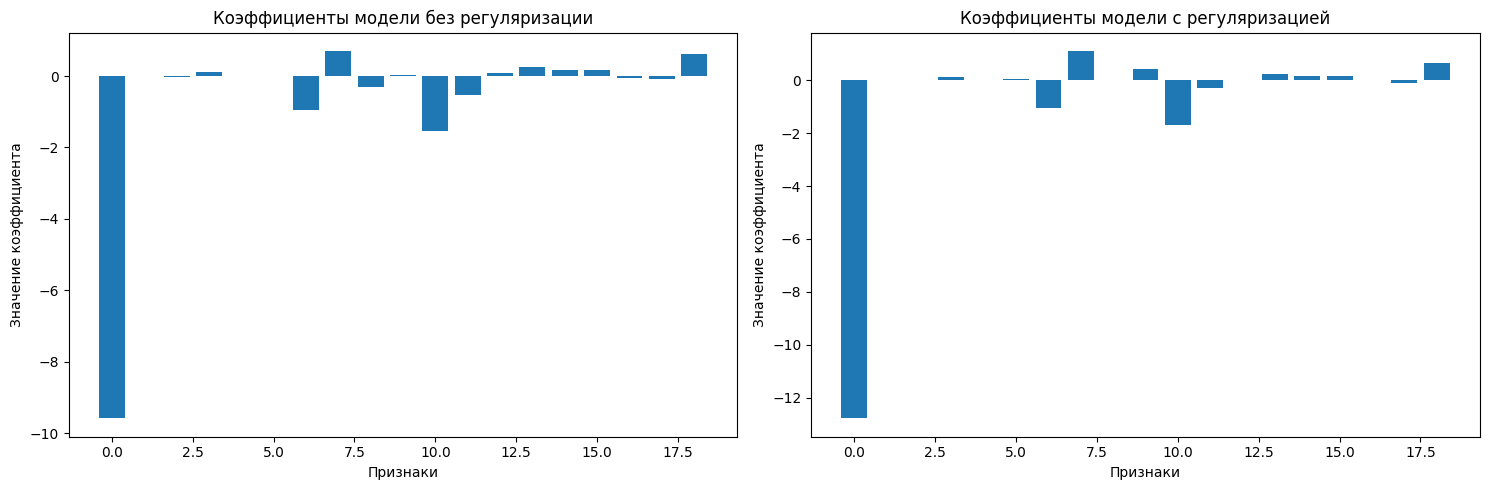

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [ ]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.8969
Точность на тестовой выборке: 0.8983

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1068
           1       0.86      0.09      0.16       132

    accuracy                           0.90      1200
   macro avg       0.88      0.54      0.56      1200
weighted avg       0.89      0.90      0.86      1200



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

(・・ ) ?


### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

Метод **Sequential Feature Selector (SFS)** — это один из методов отбора признаков, который выбирает наилучшие подмножества признаков для построения модели. Он работает по принципу итеративного добавления (или удаления) признаков, основываясь на их вкладах в качество модели.

### Описание работы Sequential Feature Selector

1. **Итеративный процесс**:
   - **Вперёд (Forward Selection)**: Начинает с пустого набора признаков и поочередно добавляет признаки, которые наилучшим образом улучшают производительность модели (например, минимизируют ошибку или максимизируют точность).
   - **Назад (Backward Elimination)**: Начинает со всех доступных признаков и удаляет наименее значимые, пока не останется нужное количество признаков или не будет достигнута желаемая производительность.

2. **Критерии оценки**:
   - На каждом шаге выбирается признак, который улучшает метрику (например, точность, F1-score и т. д.) на кросс-валидации.
   - Остановка происходит, когда добавление или удаление признака не приводит к улучшению метрики.

3. **Комбинация с моделями**:
   - SFS может быть использован в сочетании с различными моделями (например, линейная регрессия, деревья решений, SVM и т. д.), что позволяет адаптировать отбор признаков к конкретной задаче.

### Сравнение с предыдущими методами

1. **Статические методы**:
   - Методы, такие как **Filter** и **Wrapper**, основаны на различных подходах.
     - **Filter** оценивают признаки на основе статистических тестов (например, корреляция) без учета модели.
     - **Wrapper** используют выбранную модель для оценки подмножеств признаков, но могут быть вычислительно затратными.

2. **Преимущества SFS**:
   - SFS может предоставить более точные результаты, поскольку учитывает взаимодействие между признаками и их влияние на модель.
   - Итеративный подход SFS может привести к более компактному и интерпретируемому набору признаков по сравнению с другими методами.

3. **Недостатки SFS**:
   - Может быть вычислительно затратным, особенно для больших наборов данных.
   - Есть риск переобучения, если не использовать кросс-валидацию или другие методы регуляризации.

### Объяснение полученных результатов

1. **Улучшение производительности**:
   - Если результаты с использованием SFS показывают улучшение по сравнению с предыдущими методами, это может быть связано с более точным выбором признаков, которые действительно имеют значение для модели, в отличие от менее значимых признаков, которые могли быть выбраны другими методами.

2. **Потеря производительности**:
   - Если SFS не показывает улучшения, это может быть связано с избыточностью признаков или тем, что выбранные признаки не улучшают обобщающую способность модели.

3. **Кросс-валидация**:
   - Использование кросс-валидации в процессе отбора признаков может помочь избежать переобучения и предоставить более надежные оценки производительности.

### Выводы

Sequential Feature Selector является мощным инструментом для отбора признаков, особенно когда важна производительность модели и понимание ее работы. Сравнение результатов с предыдущими методами поможет определить, насколько эффективен этот метод в контексте вашей конкретной задачи.

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [ ]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [ ]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [ ]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [ ]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

K-Fold Cross-Validation - Средняя точность: 0.8966666666666667
Точности по каждому фолду: [0.9041666666666667, 0.895, 0.8941666666666667, 0.8991666666666667, 0.8908333333333334]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [ ]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

ShuffleSplit Cross-Validation - Средняя точность: 0.8997499999999998
Точности по каждому разделению: [0.8991666666666667, 0.8983333333333333, 0.8979166666666667, 0.9, 0.9033333333333333]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Анализ результатов с использованием метода отбора признаков и кросс-валидации

#### Средняя точность

Средняя точность модели составляет **0.8997**, что указывает на хорошую производительность. Это значение близко к 0.90, что означает, что модель может успешно классифицировать большую часть данных.

#### Точности по каждому разделению

Точности по каждому разделению кросс-валидации:
- **0.8991**
- **0.8983**
- **0.8979**
- **0.9**
- **0.903**

Эти значения показывают небольшие колебания в производительности модели в зависимости от разделения данных. Наиболее низкая точность наблюдается на третьем разбиении (0.8979), а наивысшая — на последнем (0.903). Это может указывать на то, что данные содержат некоторые шумовые элементы, или что в некоторых подвыборках представлено больше сложных для классификации объектов.

### Объяснение результата

1. **Сравнение средней точности с точностями разделений**:
   - Средняя точность (0.8997) является адекватным представлением производительности модели, основанным на всех разбиениях.
   - Сравнение точности на каждом разбиении показывает, что модель имеет стабильную производительность, однако существуют небольшие колебания, которые могут указывать на сложность задач классификации, представленных в данных.

2. **Отбор признаков**:
   - Использование результатов отбора признаков, основанного на наилучшей точности, может привести к улучшению производительности, так как удаляются нерелевантные или избыточные признаки, которые могут ухудшать качество предсказаний.
   - Выбор лучших признаков на основе точности позволяет модели сосредоточиться на наиболее информативных признаках, что может улучшить обобщающую способность.

### Перебор параметра `n_splits`

Кросс-валидация с различными значениями `n_splits` может помочь понять, как размер разбиений влияет на производительность модели:

1. **n_splits = 5** (как в текущем анализе):
   - Стандартное значение, дающее хороший баланс между вычислительной затратностью и надежностью оценки.

2. **n_splits = 10**:
   - Увеличение числа разбиений может привести к более надежным оценкам, но также увеличивает вычислительную сложность. Слишком маленькое количество данных в каждом разбиении может привести к нестабильности в оценках.

3. **n_splits = 3**:
   - Уменьшение числа разбиений может ускорить процесс, но снизит надежность оценок, так как модель будет тренироваться на меньшем количестве данных.

4. **n_splits = 20**:
   - Это может обеспечить более детальную оценку, но приведет к значительным вычислительным затратам. В некоторых случаях также может возникнуть проблема переобучения из-за того, что каждое разбиение будет слишком маленьким.


### Заключение

Использование метода отбора признаков и кросс-валидации значительно улучшает качество моделей. Параметр `n_splits` играет важную роль в оценке производительности модели, и его оптимизация может привести к более надежным результатам.

### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [ ]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.9041666666666667
Точность на тестовых данных: 0.8822916666666667


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Анализ результатов с отсечением выбросов и кросс-валидацией

#### Точность на валидационных и тестовых данных

- **Точность на валидационных данных**: **0.9042**
- **Точность на тестовых данных**: **0.8823**

Эти результаты показывают, что модель хорошо работает на валидационных данных, однако ее производительность на тестовых данных значительно ниже. Это может указывать на переобучение модели, когда она хорошо справляется с валидационными данными, но не обобщает свои знания на новых, невидимых данных.

### Влияние отсечения выбросов

1. **Отсечение выбросов**:
   - Удаление выбросов может значительно улучшить качество модели, так как выбросы могут вносить значительный шум в данные, искажая результаты обучения.
   - Валидационная точность 0.9042 указывает на то, что отсечение выбросов положительно сказалось на модели, позволив ей лучше адаптироваться к данным.

2. **Проблемы с тестовыми данными**:
   - Сравнение точности на валидационных и тестовых данных указывает на возможное переобучение. Если модель адаптировалась к специфическим особенностям валидационных данных, это может негативно сказаться на ее способности обобщать на тестовых данных.

### Объяснение результатов

- **Высокая точность на валидационных данных** (0.9042) может свидетельствовать о том, что модель извлекла полезные паттерны из обучающих данных, особенно после отсечения выбросов.
- **Низкая точность на тестовых данных** (0.8823) может быть вызвана тем, что модель не была достаточно адаптирована к разнообразию данных, с которыми она сталкивается на тестовой выборке.

### Перебор параметра `n_splits`

Изменение количества разбиений в кросс-валидации может помочь лучше понять, как отсечение выбросов и выбор признаков влияют на производительность модели.

1. **n_splits = 5**:
   - Позволяет получить более стабильные результаты, как показано в ваших предыдущих анализах. Это стандартный подход, обеспечивающий баланс между качеством и вычислительной нагрузкой.

2. **n_splits = 10**:
   - Увеличение числа разбиений может предоставить более точные оценки, однако может увеличить риск переобучения. В этом случае, важно следить за стабильностью результатов.

3. **n_splits = 3**:
   - Уменьшение числа разбиений может привести к менее надежным оценкам. Данные, разделенные на меньшее количество частей, могут не отразить всю сложность структуры данных.

4. **n_splits = 20**:
   - Очень большое количество разбиений может привести к чрезмерной разделимости данных, что потенциально снизит точность модели, так как каждое разбиение будет содержать меньше данных. Это может привести к тому, что модель будет переобучаться на слишком малом количестве данных в каждом разбиении.

### Заключение

Результаты показывают, что отсечение выбросов положительно повлияло на модель, но могут возникать проблемы с обобщением на тестовых данных. Параметр n_splits в кросс-валидации играет важную роль в оценке производительности, и его оптимизация может помочь улучшить качество модели.

### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

Для моего датасета подходит K-fold Cross-Validation, так как обеспечит надежную оценку производительности модели на всех доступных данных.

Если нужен более структурированный подход к оценке модели, Train-Test-Validation Split может быть предпочтительным для четкого разделения этапов обучения, настройки и тестирования модели.